**Topic Modeling on Protests Dataset using Latent Dirichlet Allocation (LDA)**

This notebook performs Latent Dirichlet Allocation (LDA) topic modeling on protest notes from the ACLED dataset for Iran. The goal is to identify coherent and distinct topics underlying protest narratives and evaluate the model's performance through coherence and topic diversity metrics.

In [41]:
#%% Imports and Environment Setup
## Loading all the packages
import pandas as pd
import re
import nltk
import random
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from wordcloud import WordCloud
from collections import Counter

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
nltk.download('stopwords')  # Downloads the stopwords corpus if not already present

# Define custom stopwords to exclude  months and common words
custom_stopwords = {"october", "january", "february", "may", "november", "december", "april", "march", "front", "plan", "outside", "building"}

# Combine NLTK's English stopwords with the custom list
stop_words = set(stopwords.words('english')).union(custom_stopwords)

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
file_path = r"/home/ubuntu/Capstone_Files/data/ACELD_Iran.csv"  # Path to the protest dataset
iran_protests_df = pd.read_csv(file_path, sep=';')  # Read CSV with semicolon delimiter

##Printing the first five rows of the dataset
iran_protests_df.head()

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp
0,IRN30318,06 February 2025,2025,1,Demonstrations,Protests,Peaceful protest,Protesters (Iran),Health Workers (Iran),Protesters,...,Lordegan,31.5134,50.8267,1,Eteraze Bazar,New media,"On 6 February 2025, nurses and health workers ...",0,crowd size=no report,1739238781
1,IRN30319,06 February 2025,2025,1,Demonstrations,Protests,Peaceful protest,Protesters (Iran),Labor Group (Iran),Protesters,...,Lavan Island,26.8074,53.3741,1,Eteraze Bazar; Human Rights Activists in Iran ...,Local partner-Other,"On 6 February 2025, Continental Plateau Oil Co...",0,crowd size=no report,1739238781
2,IRN30314,05 February 2025,2025,1,Demonstrations,Protests,Peaceful protest,Protesters (Iran),Labor Group (Iran),Protesters,...,Ahvaz,31.3190,48.6842,1,Free Union of Iranian Workers; Human Rights Ac...,Local partner-Other,"On 5 February 2025, workers at the Telecommuni...",0,crowd size=no report,1739238781
3,IRN30315,05 February 2025,2025,1,Demonstrations,Protests,Peaceful protest,Protesters (Iran),NaN,Protesters,...,Tehran - District 12,35.6810,51.4291,1,Eteraze Bazar; Free Union of Iranian Workers; ...,Local partner-Other,"On 5 February 2025, investors of Cryptoland Di...",0,crowd size=no report,1739238781
4,IRN30316,05 February 2025,2025,1,Demonstrations,Protests,Peaceful protest,Protesters (Iran),NaN,Protesters,...,Tehran - District 12,35.6810,51.4291,1,Eteraze Bazar; Iran International,New media-International,"On 5 February 2025, landowners at the 33 lands...",0,crowd size=no report,1739238781


In [ ]:
texts = iran_protests_df['notes'].astype(str).str.lower().tolist()  # Convert notes to lowercase strings

def preprocess(text):
    """
    Tokenize and preprocess input text.
    Input:
        text (str): raw text string to process
    Output:
        List[str]: list of cleaned tokens
    """
    # Tokenize text into words, remove non-alphanumeric characters
    tokens = simple_preprocess(text, deacc=True)
    # Remove stopwords and words with shorter than three characters
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Apply preprocessing to all documents
processed_texts = [preprocess(text) for text in texts]

In [45]:
# Generate and display a word cloud from preprocessed texts
all_words = [word for text in processed_texts for word in text]  # Flatten list of tokens

TThe code below generates and displays a word cloud of the most frequent words from the preprocessed protest texts.

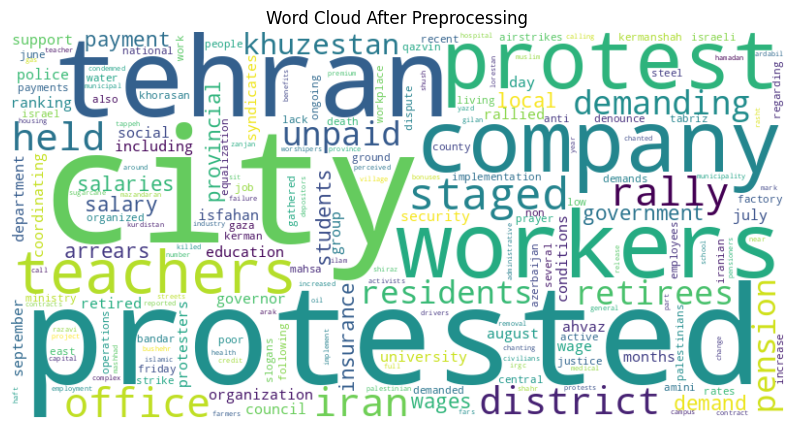

In [46]:
word_counts = Counter(all_words)  # Count word frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 6))  # Set figure size
plt.imshow(wordcloud, interpolation='bilinear')  # Display the word cloud
plt.axis('off')  # Turn off axes
plt.title("Word Cloud After Preprocessing")  # Add title
plt.show()  # Render the plot

In [47]:
## corpora.Dictionary(processed_texts): Creates a mapping of each unique word to a unique ID — essential for converting words into numerical form

dictionary = corpora.Dictionary(processed_texts) 

In [48]:
## filter_extremes(no_below=5, no_above=0.3): Removes extremely rare words (appear in fewer than 5 documents) and overly common ones (appear in more than 30% of documents) to reduce noise and improve model quality.

dictionary.filter_extremes(no_below=5, no_above=0.3)

In [49]:
## corpus = [dictionary.doc2bow(text) for text in processed_texts]: Converts each document into a bag-of-words (BoW) format — a list of (word_id, frequency) pairs — which is the required input format for the LDA model.


corpus = [dictionary.doc2bow(text) for text in processed_texts]

### Topic Diversity

**What it is:**  
Topic Diversity measures how distinct the top words are across all topics. A higher score indicates less overlap in the most important words between topics, suggesting more distinctive topic representations.

**Formula:**  

$
\text{Topic Diversity} = \frac{\lvert \bigcup_{t=1}^{T} W_t \rvert}{T \times k}
$

- $T$ = number of topics (excluding the “noise” topic)  
- $k$ = number of top words considered per topic  
- $W_t$ = set of the top $k$ words for topic $t$
- $U_{t=1}^{T} W_t$ = union of all these top‑word sets  

So you collect the top‑k words from each of the T topics, count how many unique words appear in total, and divide by T x k. A value of 1.0 means no overlap; lower values indicate more shared terms across topics.  

In [50]:
def compute_topic_diversity(model, topk=10):
    """
    Compute topic diversity metric.
    Input:
        model (gensim.models.LdaModel): trained LDA model
        topk (int): number of top words per topic to consider
    Output:
        float: topic diversity score (unique words / total words)
    """
    # Get top words for each topic
    top_words_per_topic = [set([word for word, _ in model.show_topic(topicid, topk)])
                           for topicid in range(model.num_topics)]
    all_top_words = [word for topic in top_words_per_topic for word in topic]
    unique_top_words = set(all_top_words)
    # Calculate diversity as ratio of unique top words to total top words
    topic_diversity = len(unique_top_words) / (topk * model.num_topics)
    return topic_diversity

Alpha (α) controls the sparsity of the document-topic distribution (lower = fewer topics per document).

Eta (η) controls the sparsity of the topic-word distribution (lower = fewer words per topic).

Passes is the number of full passes through the corpus during training (higher = better convergence).

Update_every defines how often the model is updated (0 = batch training).

Chunksize is the number of documents processed in each training chunk (affects memory and speed).

The **C_V Coherence Score** assesses how semantically coherent the top words within a topic are, based on how often they appear together in the original texts and how similar their meanings are.

A higher C_V score indicates that:

-- The top words in a topic frequently occur together.

-- The words are semantically related.

The C_V score combines two key concepts:

Co-occurrence Frequency: Measures how often pairs of top words in a topic appear together in a sliding window across the original texts.

Semantic Similarity: Evaluates how similar these word pairs are in meaning, typically using cosine similarity over word embeddings.

These values are combined using a statistical measure called Normalized Pointwise Mutual Information (NPMI) and aggregated to produce a single coherence score for each topic.


### 🧮 C_V Coherence Score Formula

The C_V coherence score is calculated as:

$$
C_V = \frac{1}{|W|} \sum_{w_i, w_j \in W} \text{NPMI}(w_i, w_j) \cdot \text{cosine\_similarity}(w_i, w_j)
$$

Where:  
$W$ is the set of top words in a topic  
$\text{NPMI}(w_i, w_j)$ is the Normalized Pointwise Mutual Information between words $w_i$ and $w_j$  
$\text{cosine\_similarity}(w_i, w_j)$ is the semantic similarity between word embeddings of $w_i$ and $w_j$

We initially conducted a grid search by varying the number of topics from 5 to 16, evaluating each model using coherence and topic diversity scores. The model achieved the best performance at 5 topics, which we selected for further analysi

In [ ]:
# Grid search over hyperparameters alpha and eta for fixed number of topics
topic_numbers = [5]  # Number of topics to evaluate
alpha_values = ['symmetric', 'asymmetric', 0.01, 0.05, 0.1, 0.5, 'auto']  # Prior for document-topic distribution
eta_values = ['symmetric', 0.01, 0.05, 0.1, 0.5, 'auto']  # Prior for topic-word distribution
best_overall_model = None
overall_best_score = float('-inf')  # Initialize best coherence score
overall_best_params = {}

for num_topics in topic_numbers:
    print(f"\nRunning Grid Search for Num Topics: {num_topics}")
    for alpha in alpha_values:
        for eta in eta_values:
            # Train LDA model with current parameters
            lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                                 random_state=42, passes=100, alpha=alpha, eta=eta,
                                 update_every=0, chunksize=5000)
            # Compute coherence score
            coherence_model = CoherenceModel(model=lda_model, texts=processed_texts,
                                             dictionary=dictionary, coherence='c_v', processes=4)
            coherence_score = coherence_model.get_coherence()
            print(f"Num Topics: {num_topics}, Alpha: {alpha}, Eta: {eta}, Coherence Score: {coherence_score:.4f}")

            # Update best model if score improves
            if coherence_score > overall_best_score:
                overall_best_score = coherence_score
                overall_best_params = {'alpha': alpha, 'eta': eta, 'num_topics': num_topics}
                best_overall_model = lda_model


Running Grid Search for Num Topics: 5


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Num Topics: 5, Alpha: symmetric, Eta: symmetric, Coherence Score: 0.5667


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Num Topics: 5, Alpha: symmetric, Eta: 0.01, Coherence Score: 0.5748


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Num Topics: 5, Alpha: symmetric, Eta: 0.05, Coherence Score: 0.5774


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Num Topics: 5, Alpha: symmetric, Eta: 0.1, Coherence Score: 0.5724


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Num Topics: 5, Alpha: symmetric, Eta: 0.5, Coherence Score: 0.5540


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Num Topics: 5, Alpha: symmetric, Eta: auto, Coherence Score: 0.5667


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Num Topics: 5, Alpha: asymmetric, Eta: symmetric, Coherence Score: 0.6007


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Num Topics: 5, Alpha: asymmetric, Eta: 0.01, Coherence Score: 0.5911


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Num Topics: 5, Alpha: asymmetric, Eta: 0.05, Coherence Score: 0.5984


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Num Topics: 5, Alpha: asymmetric, Eta: 0.1, Coherence Score: 0.5944


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Num Topics: 5, Alpha: asymmetric, Eta: 0.5, Coherence Score: 0.6039


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1705) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Num Topics: 5, Alpha: asymmetric, Eta: auto, Coherence Score: 0.6007


In [ ]:
# Display optimal parameters and best coherence score
optimal_num_topics = overall_best_params['num_topics']
optimal_alpha = overall_best_params['alpha']
optimal_eta = overall_best_params['eta']

print(f"\nOptimal parameters - Num Topics: {optimal_num_topics}, Alpha: {optimal_alpha}, Eta: {optimal_eta}")
print(f"Best Coherence Score: {overall_best_score:.4f}")

In [ ]:
# Compute and display topic diversity for final model
final_topic_diversity = compute_topic_diversity(best_overall_model, topk=10)
print(f"Final Model Topic Diversity: {final_topic_diversity:.4f}")

The below bar chart shows the top 10 words for each LDA topic, based on how frequently those words appear across all documents. It helps interpret each topic by highlighting its most representative and frequently used words.

In [ ]:
# Loop through each topic
for topic_id in range(optimal_num_topics):
    # Get the top 10 words for the current topic
    top_words = [word for word, _ in best_overall_model.show_topic(topic_id, topn=10)]

    # Count how many documents each word appears in
    word_freqs = [sum([1 for doc in processed_texts if word in doc]) for word in top_words]

    # Sort the words by frequency in descending order
    sorted_pairs = sorted(zip(top_words, word_freqs), key=lambda x: x[1], reverse=True)
    words, freqs = zip(*sorted_pairs)  # Unzip into separate lists

    # Set up the figure for the bar chart
    plt.figure(figsize=(10, 6))

    # Plot the bar chart
    bars = plt.bar(words, freqs)

    # Add axis labels and title
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Words for Topic {topic_id}')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    # Annotate each bar with its frequency value
    for bar, freq in zip(bars, freqs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(freq),
                 ha='center', va='bottom')

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    # Display the plot
    plt.show()


The below table shows 10 randomly selected documents, showing each document's dominant topic, its topic probability, and which of the topic's top 10 words are actually present in the document. This helps validate the topic assignments and understand how well the topics match the content.

In [ ]:
# Randomly select 10 document indices from the dataset
random_docs = random.sample(range(len(processed_texts)), 10)

# Initialize list to store document-topic information
document_data = []

# Loop through each selected document
for doc_id in random_docs:
    # Get the topic distribution for the current document
    topic_probs = best_overall_model.get_document_topics(corpus[doc_id])
    topic_probs.sort(key=lambda x: x[1], reverse=True)  # Sort topics by descending probability

    # Select the dominant topic (with the highest probability)
    dominant_topic, prob = topic_probs[0]

    # Get the top 10 words for the dominant topic
    top_words = [word for word, _ in best_overall_model.show_topic(dominant_topic, topn=10)]

    # Find which of the top topic words are present in the document
    matched = [word for word in top_words if word in processed_texts[doc_id]]

    # Get the original (raw) document text
    document_text = iran_protests_df.iloc[doc_id]['notes']

    # Store the results in a list: [raw text, dominant topic, topic probability, matched words]
    document_data.append([
        document_text,
        dominant_topic,
        prob,
        ', '.join(matched) if matched else 'None'  # If no matches, mark as 'None'
    ])

# Create a DataFrame to display the results in a table format
doc_table = pd.DataFrame(document_data, columns=[
    'Document Text', 'Dominant Topic', 'Probability', 'Matched Words'
])

# Show the table
doc_table

The below  visualization displays bar plots of topic probabilities for 2 randomly selected documents. It shows how each document is distributed across different topics, highlighting the dominant topic and illustrating the model’s ability to assign multiple topic proportions per document.

In [ ]:
# Randomly select 2 document indices for visualization
random_docs = random.sample(range(len(processed_texts)), 2)

# Loop through each selected document
for doc_id in random_docs:
    # Get the topic distribution for the current document
    topic_probs = best_overall_model.get_document_topics(corpus[doc_id])
    topic_probs.sort(key=lambda x: x[1], reverse=True)  # Sort by descending topic probability

    # Format topic labels (e.g., "Topic 0", "Topic 1", ...) for the x-axis
    topics = [f"Topic {t[0]}" for t in topic_probs]
    # Extract the corresponding probability values
    probs = [t[1] for t in topic_probs]

    # Print the original document text
    print(f"\nDocument {doc_id}: {iran_protests_df.iloc[doc_id]['notes']}")

    # Create bar plot to show topic distribution
    plt.figure(figsize=(8, 4))
    bars = plt.bar(topics, probs)  # Plot each topic's probability
    plt.xlabel('Topics')
    plt.ylabel('Probability')
    plt.title(f'Topic Distribution for Document {doc_id}')
    plt.ylim(0, 1)  # Set y-axis range from 0 to 1

    # Annotate each bar with its probability value
    for bar, p in zip(bars, probs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{p:.2f}",
                 ha='center', va='bottom')

    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()  # Render the plot

Below code saves an interactive LDA visualization using pyLDAvis, which helps explore topics, their distributions, and top keywords in a visually intuitive way. It shows how topics relate to each other (via inter-topic distance) and how words contribute to each topic.

In [ ]:
# Prepare the interactive LDA visualization data using pyLDAvis
lda_vis_data = gensimvis.prepare(best_overall_model, corpus, dictionary)

pyLDAvis.enable_notebook()

pyLDAvis.display(lda_vis_data)
